# Identifying Duplicate Questions

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-notebook')

print('# File sizes')
for f in os.listdir('../input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

# File sizes
test.csv                      314.02MB



## Training set

In [2]:
df_train = pd.read_csv('../input/train.csv.zip')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We are given a minimal number of data fields here, consisting of:

**`id`:** Looks like a simple rowID    
**`qid{1, 2}`:** The unique ID of each question in the pair    
**`question{1, 2}`:** The actual textual contents of the questions.    
**`is_duplicate`:** The **label** that we are trying to predict - whether the two questions are duplicates of each other.

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780
Maximum number of times a single question is repeated: 157



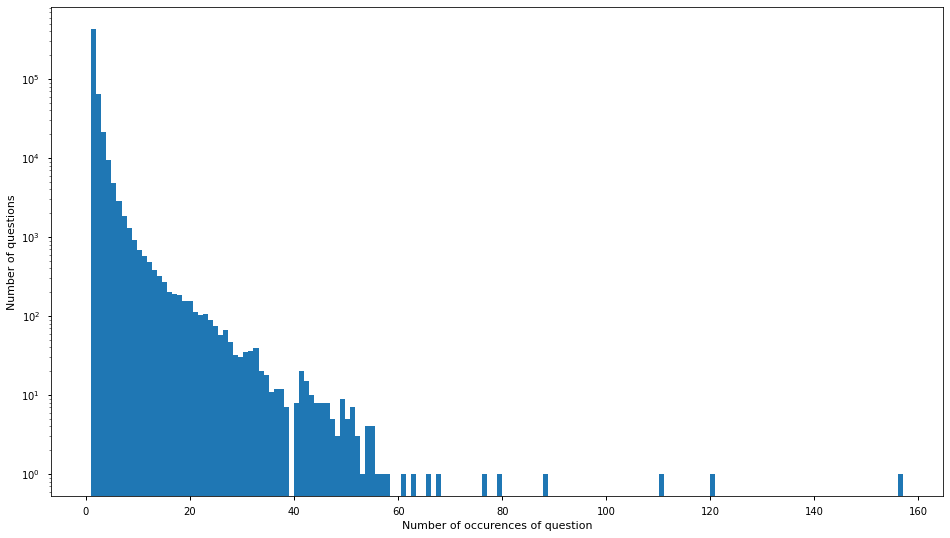

In [3]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(16, 9))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonpositive='clip')
# plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In terms of questions, everything looks as I would expect here. Most questions only appear a few times, with very few questions appearing several times (and a few questions appearing many times). One question appears more than 160 times, but this is an outlier.

We can see that we have a 37% positive class in this dataset. Since we are using the [LogLoss](https://www.kaggle.com/wiki/LogarithmicLoss) metric, and LogLoss looks at the actual predicts as opposed to the order of predictions, we should be able to get a decent score by creating a submission predicting the mean value of the label.

<AxesSubplot:ylabel='id'>

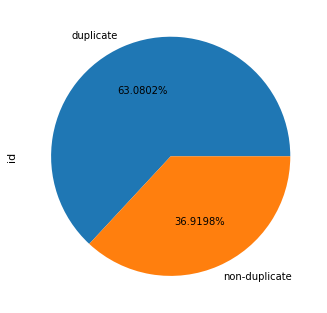

In [4]:
df_train.groupby('is_duplicate')['id'].count().plot.pie(autopct='%1.04f%%', labels={'non-duplicate', 'duplicate'})


## Text analysis

mean-train 59.82 std-train 31.96 max-train 1169.00


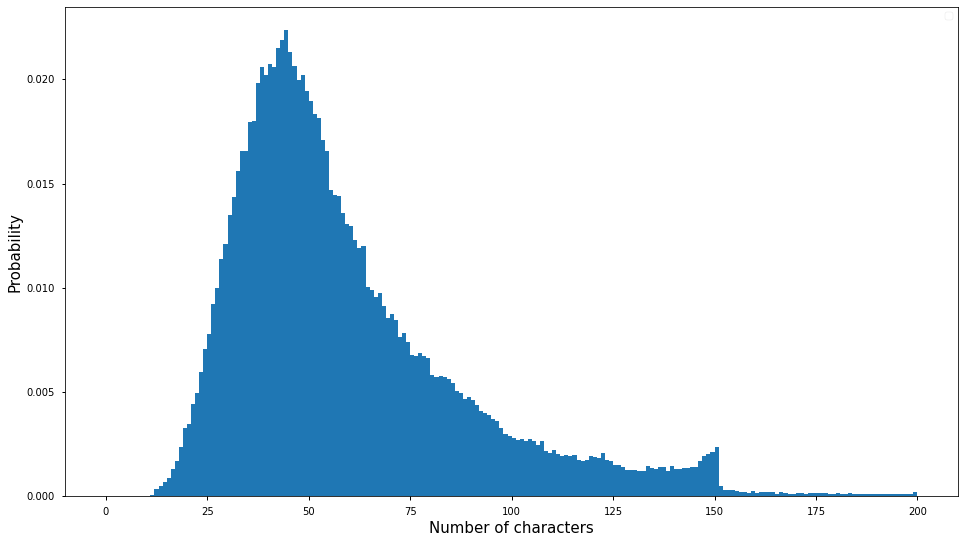

In [5]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
dist_train = train_qs.apply(len)
plt.figure(figsize=(16, 9))
plt.hist(dist_train, bins=200, range=[0, 200], density=True)
# plt.title('Histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} max-train {:.2f}'.format(dist_train.mean(), dist_train.std(), dist_train.max()))

We can see that most questions have anywhere from 15 to 150 characters in them. It seems that the test distribution is a little different from the train one, but not too much so (I can't tell if it is just the larger data reducing noise, but it also seems like the distribution is a lot smoother in the test set).

One thing that catches my eye is the steep cut-off at 150 characters for the training set, for most questions, while the test set slowly decreases after 150. Could this be some sort of Quora question size limit?

It's also worth noting that I've truncated this histogram at 200 characters, and that the max of the distribution is at just under 1200 characters for both sets - although samples with over 200 characters are very rare.

Let's do the same for word count. I'll be using a naive method for splitting words (splitting on spaces instead of using a serious tokenizer), although this should still give us a good idea of the distribution.

mean-train 11.06 std-train 5.89 max-train


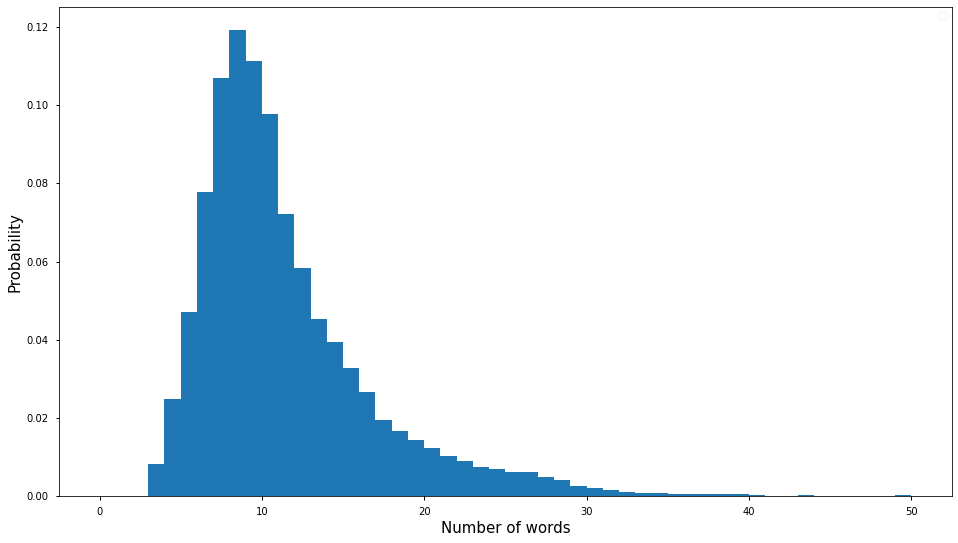

In [6]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
plt.figure(figsize=(16, 9))
plt.hist(dist_train, bins=50, range=[0, 50],density=True)
# plt.title('Histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} max-train'.format(dist_train.mean(), dist_train.std(), dist_train.max()))

We see a similar distribution for word count, with most questions being about 10 words long. It looks to me like the distribution of the training set seems more "pointy", while on the test set it is wider. Nevertheless, they are quite similar.

So what are the most common words? Let's take a look at a word cloud.

## Semantic Analysis

Next, I will take a look at usage of different punctuation in questions - this may form a basis for some interesting features later on.

In [7]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


# Initial Feature Analysis

Before we create a model, we should take a look at how powerful some features are. I will start off with the word share feature from the benchmark model.

Text(0.5, 0, 'word_match_share')

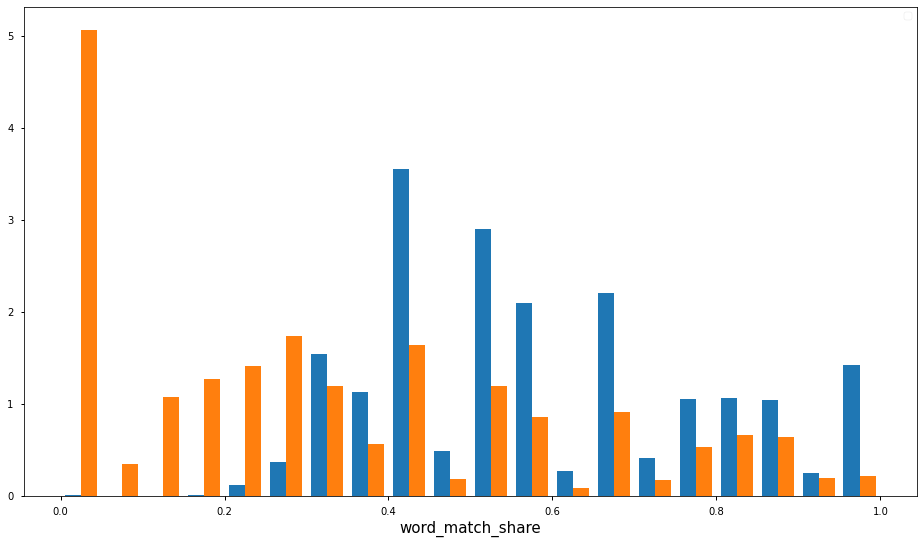

In [8]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    return (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))

plt.figure(figsize=(16, 9))
train_word_match = df_train.apply(lambda row: word_match_share(row), axis=1)
plt.hist([train_word_match[df_train['is_duplicate'] == 0], train_word_match[df_train['is_duplicate'] == 1]], bins=20, density=True)
plt.legend()
# plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

using something called TF-IDF (term-frequency-inverse-document-frequency). This means that we weigh the terms by how uncommon they are, meaning that we care more about rare words existing in both questions than common one. This makes sense, as for example we care more about whether the word "exercise" appears in both than the word "and" - as uncommon words will be more indicative of the content.Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

## TF-IDF

I'm now going to try to improve this feature, by using something called TF-IDF (term-frequency-inverse-document-frequency). This means that we weigh the terms by how **uncommon** they are, meaning that we care more about rare words existing in both questions than common one. This makes sense, as for example we care more about whether the word "exercise" appears in both than the word "and" - as uncommon words will be more indicative of the content.

You may want to look into using sklearn's [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute weights if you are implementing this yourself, but as I am too lazy to read the documentation I will write a version in pure python with a few changes which I believe should help the score.

In [9]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [10]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    return np.sum(shared_weights) / np.sum(total_weights)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 0, 'word_match_share')

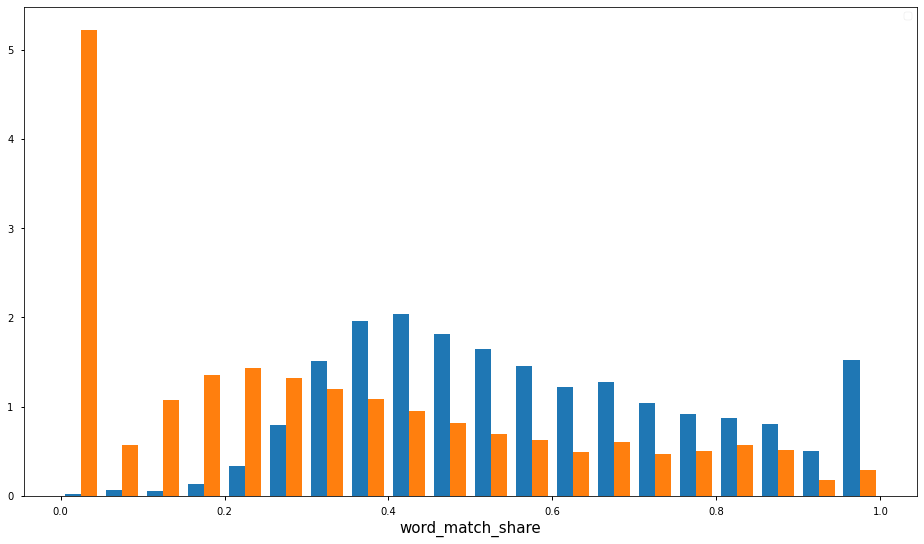

In [11]:
plt.figure(figsize=(16, 9))
tfidf_train_word_match = df_train.apply(lambda row: tfidf_word_match_share(row), axis=1)
plt.hist([tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0)], bins=20, density=True)
plt.legend()
# plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [12]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7804327049353577
   TFIDF AUC: 0.7704802292218704


So it looks like our TF-IDF actually got _worse_ in terms of overall AUC, which is a bit disappointing. (I am using the AUC metric since it is unaffected by scaling and similar, so it is a good metric for testing the predictive power of individual features.

However, I still think that this feature should provide some extra information which is not provided by the original feature. Our next job is to combine these features and use it to make a prediction. For this, I will use our old friend XGBoost to make a classification model.

In [13]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split, KFold

kfold = KFold(n_splits=10)


Evaluate with Recall

In [14]:
from sklearn.metrics import confusion_matrix

recalls = []
predicteds = []
f1s = []
accuracies = []
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    r = A[1][1]
    p = B[1][1]
    predicteds.append(p)
    recalls.append(r)    
    f1s.append(2*p*r/(p+r))
    accuracies.append((C[0][0]+C[1][1])/(C[0][0]+C[0][1]+C[1][0]+C[1][1]))
    
    plt.figure(figsize=(16,4))
    
    labels = ['non-duplicate', 'duplicate']
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".0f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Original')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.title("Recall matrix")
    
    plt.show()   

## XGBoost

Now we can finally run XGBoost on our data, in order to see the score on the leaderboard!

In [15]:
import xgboost as xgb

params = {}
params['gpu_id'] = 0
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4
params['predictor'] = 'gpu_predictor'
params['tree_method'] = 'gpu_hist'

y = df_train['is_duplicate'].fillna(0).values

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68624	test-logloss:0.68621
[100]	train-logloss:0.48104	test-logloss:0.47961
[200]	train-logloss:0.46366	test-logloss:0.46204
[300]	train-logloss:0.46055	test-logloss:0.45925
[399]	train-logloss:0.45911	test-logloss:0.45804


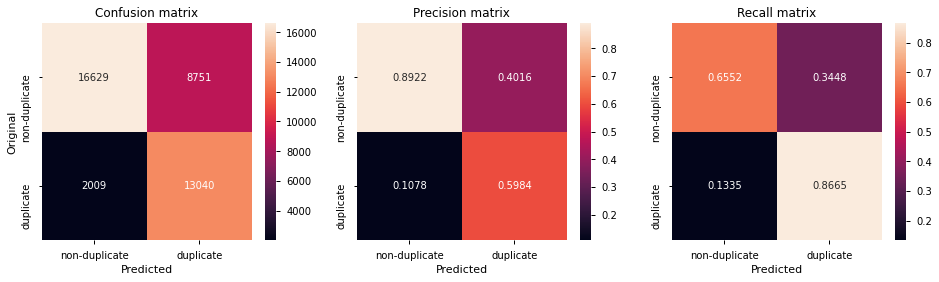

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68623	test-logloss:0.68622
[100]	train-logloss:0.48094	test-logloss:0.48048
[200]	train-logloss:0.46361	test-logloss:0.46304
[300]	train-logloss:0.46057	test-logloss:0.45993
[399]	train-logloss:0.45913	test-logloss:0.45856


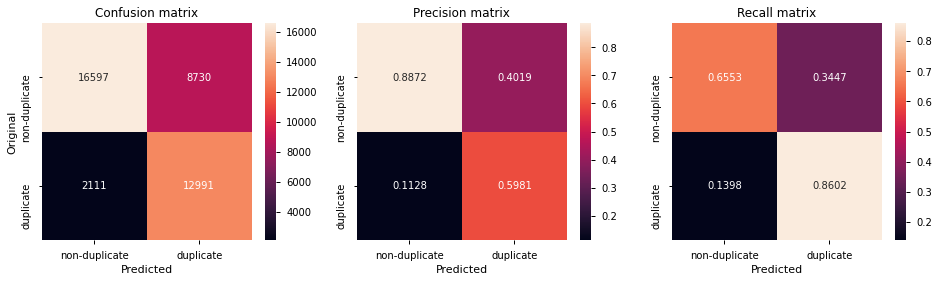

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68622	test-logloss:0.68628
[100]	train-logloss:0.48059	test-logloss:0.48286
[200]	train-logloss:0.46328	test-logloss:0.46590
[300]	train-logloss:0.46025	test-logloss:0.46311
[399]	train-logloss:0.45871	test-logloss:0.46174


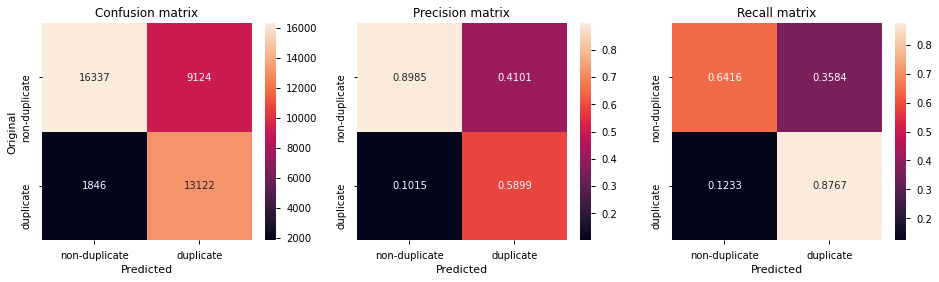

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68623	test-logloss:0.68625
[100]	train-logloss:0.48079	test-logloss:0.48154
[200]	train-logloss:0.46349	test-logloss:0.46418
[300]	train-logloss:0.46049	test-logloss:0.46095
[399]	train-logloss:0.45904	test-logloss:0.45939


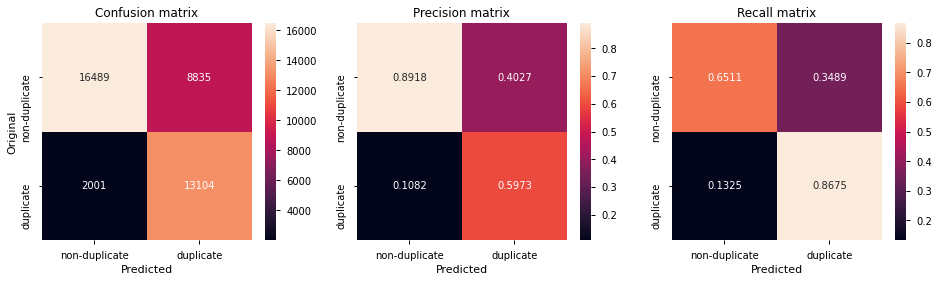

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68622	test-logloss:0.68630
[100]	train-logloss:0.48045	test-logloss:0.48394
[200]	train-logloss:0.46307	test-logloss:0.46744
[300]	train-logloss:0.46005	test-logloss:0.46481
[399]	train-logloss:0.45865	test-logloss:0.46362


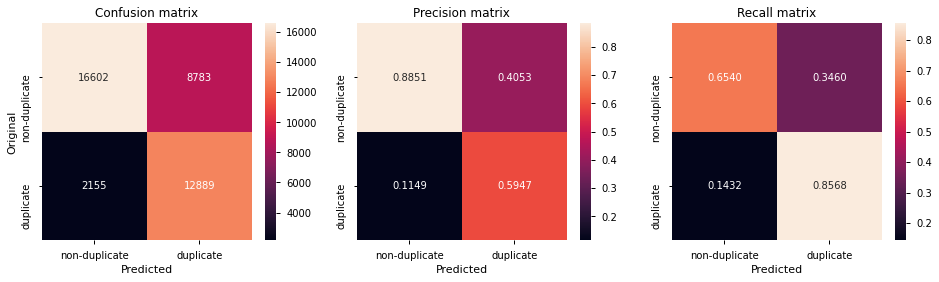

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68622	test-logloss:0.68629
[100]	train-logloss:0.48070	test-logloss:0.48221
[200]	train-logloss:0.46335	test-logloss:0.46511
[300]	train-logloss:0.46031	test-logloss:0.46230
[399]	train-logloss:0.45887	test-logloss:0.46105


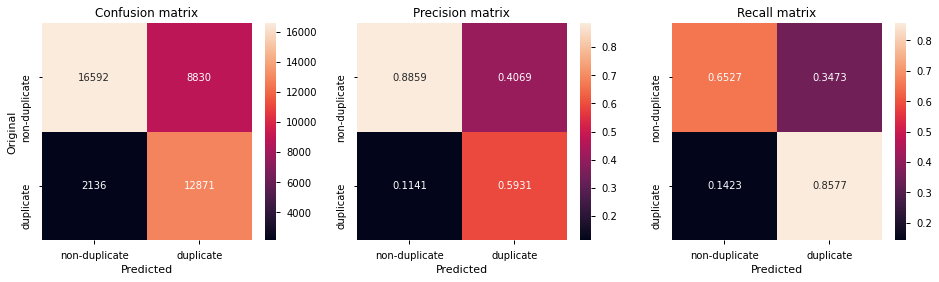

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68623	test-logloss:0.68618
[100]	train-logloss:0.48092	test-logloss:0.47981
[200]	train-logloss:0.46362	test-logloss:0.46248
[300]	train-logloss:0.46063	test-logloss:0.45957
[399]	train-logloss:0.45917	test-logloss:0.45827


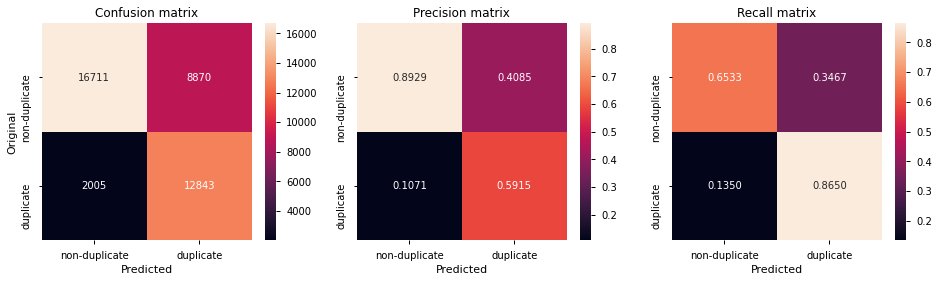

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68623	test-logloss:0.68623
[100]	train-logloss:0.48101	test-logloss:0.47979
[200]	train-logloss:0.46373	test-logloss:0.46200
[300]	train-logloss:0.46065	test-logloss:0.45877
[399]	train-logloss:0.45917	test-logloss:0.45724


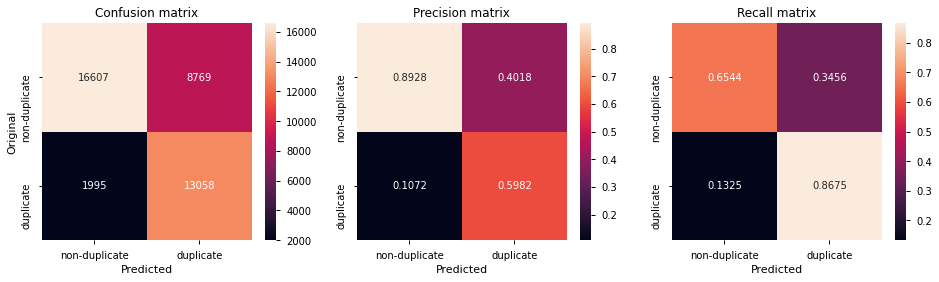

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68622	test-logloss:0.68626
[100]	train-logloss:0.48069	test-logloss:0.48251
[200]	train-logloss:0.46328	test-logloss:0.46567
[300]	train-logloss:0.46023	test-logloss:0.46296
[399]	train-logloss:0.45879	test-logloss:0.46176


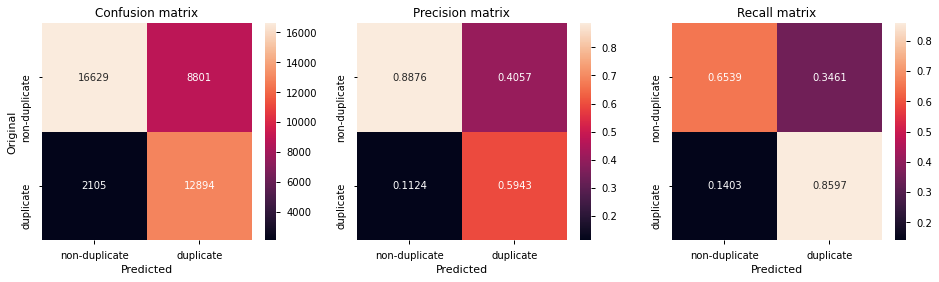

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68624	test-logloss:0.68608
[100]	train-logloss:0.48128	test-logloss:0.47705
[200]	train-logloss:0.46400	test-logloss:0.45948
[300]	train-logloss:0.46098	test-logloss:0.45639
[399]	train-logloss:0.45960	test-logloss:0.45509


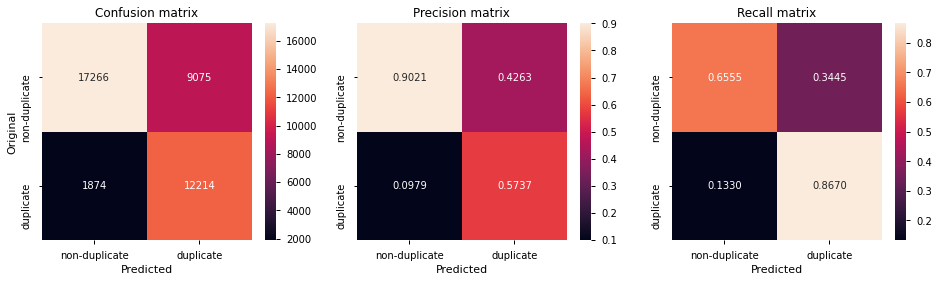

AVG Predicted 0.5929 Recall 0.8644 F1 0.7034 Accuracy 0.7309


In [16]:
for train_idx, test_idx in kfold.split(train_word_match):
    print(train_idx, test_idx)
    x_train = pd.DataFrame()
    x_test = pd.DataFrame()
    
    x_train['word_match'] = train_word_match[train_idx]
    x_train['tfidf_word_match'] = tfidf_train_word_match[train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test['word_match'] = train_word_match[test_idx]
    x_test['tfidf_word_match'] = tfidf_train_word_match[test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
    
print("AVG Predicted {:.4f} Recall {:.4f} F1 {:.4f} Accuracy {:.4f}".format(np.average(predicteds), np.average(recalls), np.average(f1s), np.average(accuracies)))
recalls.clear()
accuracies.clear()
predicteds.clear()
f1s.clear()

## Words embbedings approach

Using SBERT

In [17]:
!pip install sentence_transformers

     |████████████████████████████████| 81 kB 1.9 MB/s eta 0:00:011
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.1-py3-none-any.whl size=123336 sha256=b761a84c63e2e3a98f1f966472c24bbfc04dcaa14d11f07669314266a3319c60
  Stored in directory: /root/.cache/pip/wheels/9d/f2/81/9a97074f4974b3ade9fee286b3ea9acba88e7c9282928ba187
Successfully built sentence-transformers


Cleanning data

In [18]:
from nltk.stem.wordnet import WordNetLemmatizer

wnl = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower().replace(r'[^\x00-\x7f]', r' ')
    for c in [",", "!", ".", "?", '"', ":", ";", "[", "]", "{", "}", "<", ">"]:
        text = text.replace(c, " ")
    tokens = text.split(" ")
    tokens = [wnl.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stops]
    return " ".join(tokens)

clean_text("What's the approx annual cost of living while studying in UIC Chicago, for an Indian student?")

"what's approx annual cost living studying uic chicago  indian student "

Compute similarity of each pair

In [19]:
from sentence_transformers import SentenceTransformer, util

sbert_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

sub_set_size = 32768
cosine_sim = []
total_subset = len(df_train) // sub_set_size # large dataset

for g, sub_df in df_train.groupby(np.arange(len(df_train)) // sub_set_size):
    print("Processing group", g, total_subset)
    question1 = sub_df['question1'].tolist()
    question2 = sub_df['question2'].tolist()
    cleaned_q1 = [clean_text(q) for q in question1]
    cleaned_q2 = [clean_text(q) for q in question2]

    embeddings1 = sbert_model.encode(cleaned_q1, convert_to_tensor=True)
    embeddings2 = sbert_model.encode(cleaned_q2, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    sub_cosine_sim = [cosine_scores[ir][ir].item() for ir in range(len(cleaned_q1))]
    del embeddings1, embeddings2, cleaned_q1, cleaned_q2, question1, question2, cosine_scores

    cosine_sim.extend(sub_cosine_sim)

  0%|          | 0.00/306M [00:00<?, ?B/s]

Processing group 0 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 1 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 2 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 3 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 4 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 5 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 6 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 7 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 8 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 9 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 10 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 11 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 12 12


Batches:   0%|          | 0/347 [00:00<?, ?it/s]

Batches:   0%|          | 0/347 [00:00<?, ?it/s]

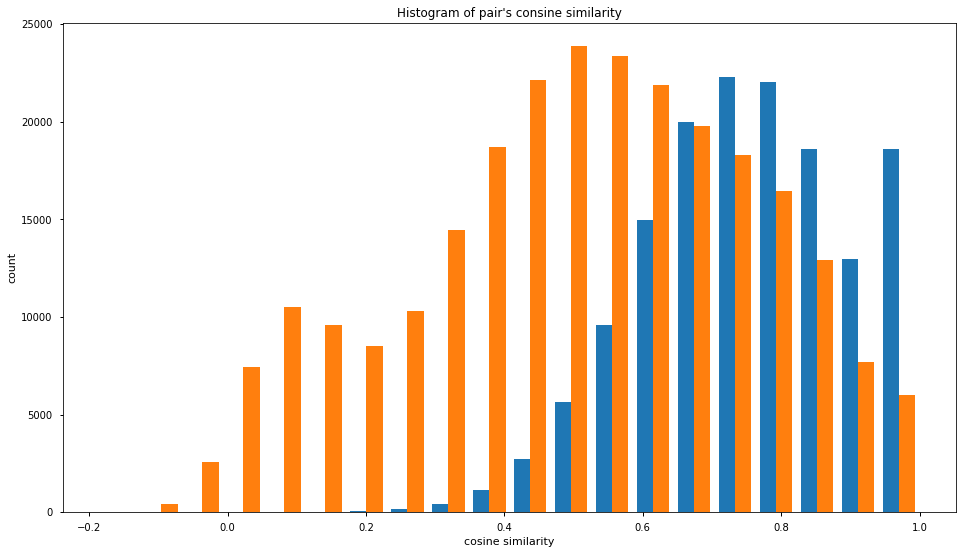

In [20]:
is_duplicated = df_train['is_duplicate'].tolist()

cosine_sim_duplicate = [cosine_sim[idx] for idx,val in enumerate(is_duplicated) if val == 1]
cosine_sim_nonduplicate = [cosine_sim[idx] for idx,val in enumerate(is_duplicated) if val == 0]

plt.figure(figsize=(16, 9))
# plt.yscale('log')
plt.hist([cosine_sim_duplicate, cosine_sim_nonduplicate], bins=20, label=['duplicate', 'non-duplicate'])
plt.title("Histogram of pair's consine similarity")
plt.xlabel('cosine similarity')
plt.ylabel('count')
print()

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68720	test-logloss:0.68722
[100]	train-logloss:0.51855	test-logloss:0.52022
[200]	train-logloss:0.50851	test-logloss:0.51048
[300]	train-logloss:0.50775	test-logloss:0.50977
[399]	train-logloss:0.50767	test-logloss:0.50974


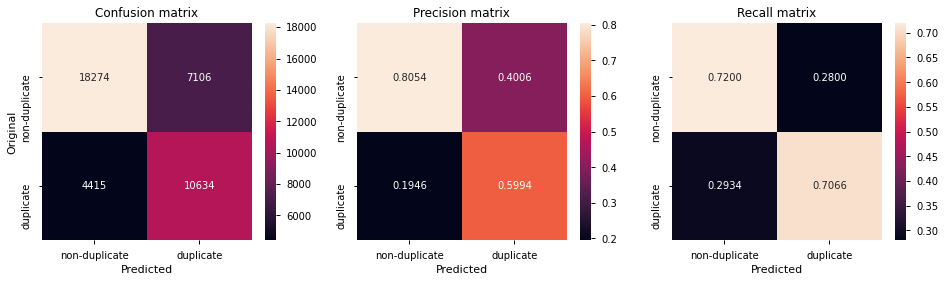

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68719	test-logloss:0.68724
[100]	train-logloss:0.51860	test-logloss:0.52001
[200]	train-logloss:0.50855	test-logloss:0.51019
[300]	train-logloss:0.50778	test-logloss:0.50952
[399]	train-logloss:0.50770	test-logloss:0.50951


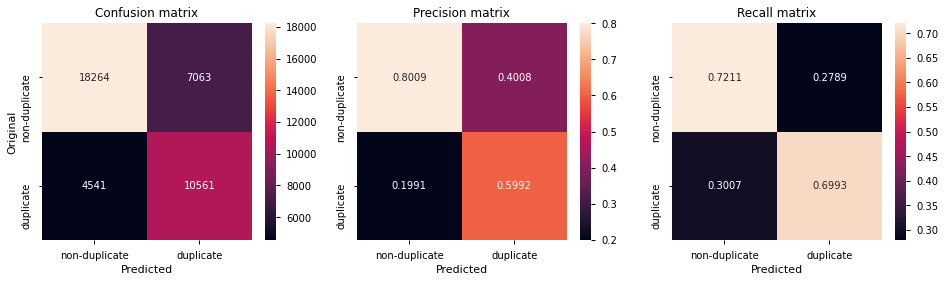

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68720	test-logloss:0.68724
[100]	train-logloss:0.51867	test-logloss:0.51947
[200]	train-logloss:0.50862	test-logloss:0.50942
[300]	train-logloss:0.50786	test-logloss:0.50873
[399]	train-logloss:0.50777	test-logloss:0.50869


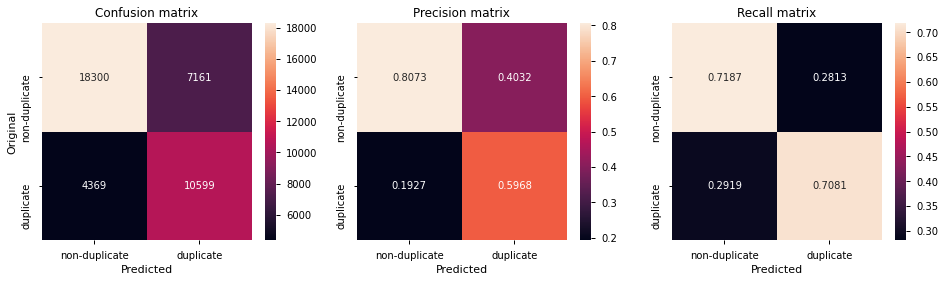

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68719	test-logloss:0.68722
[100]	train-logloss:0.51850	test-logloss:0.52043
[200]	train-logloss:0.50843	test-logloss:0.51106
[300]	train-logloss:0.50767	test-logloss:0.51046
[399]	train-logloss:0.50759	test-logloss:0.51043


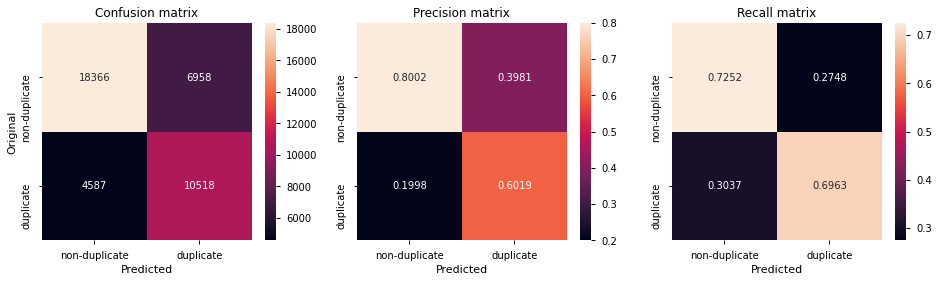

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68718	test-logloss:0.68729
[100]	train-logloss:0.51824	test-logloss:0.52265
[200]	train-logloss:0.50819	test-logloss:0.51322
[300]	train-logloss:0.50742	test-logloss:0.51259
[399]	train-logloss:0.50734	test-logloss:0.51257


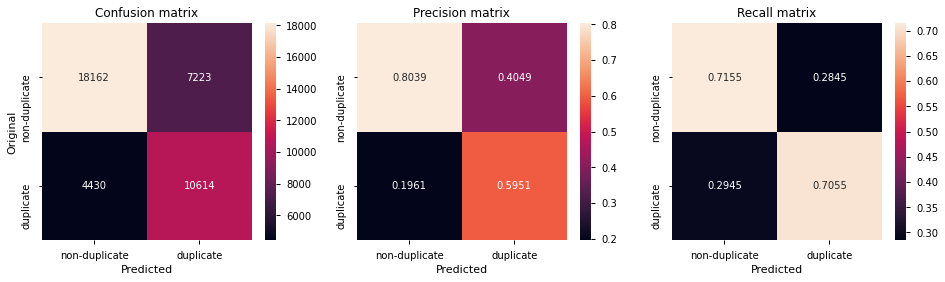

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68719	test-logloss:0.68724
[100]	train-logloss:0.51849	test-logloss:0.52061
[200]	train-logloss:0.50842	test-logloss:0.51122
[300]	train-logloss:0.50765	test-logloss:0.51067
[379]	train-logloss:0.50757	test-logloss:0.51068


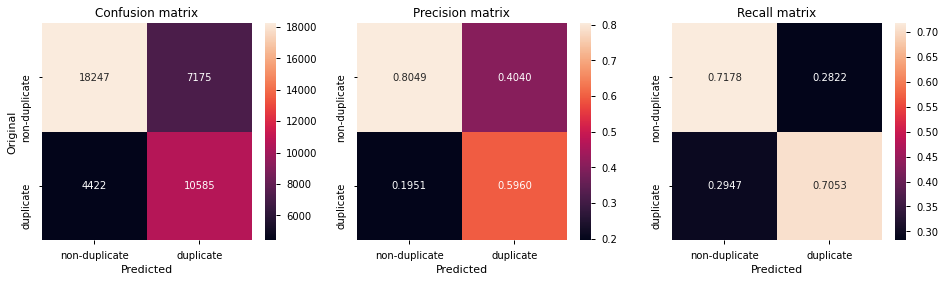

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68720	test-logloss:0.68715
[100]	train-logloss:0.51898	test-logloss:0.51678
[200]	train-logloss:0.50898	test-logloss:0.50637
[300]	train-logloss:0.50822	test-logloss:0.50557
[396]	train-logloss:0.50813	test-logloss:0.50555


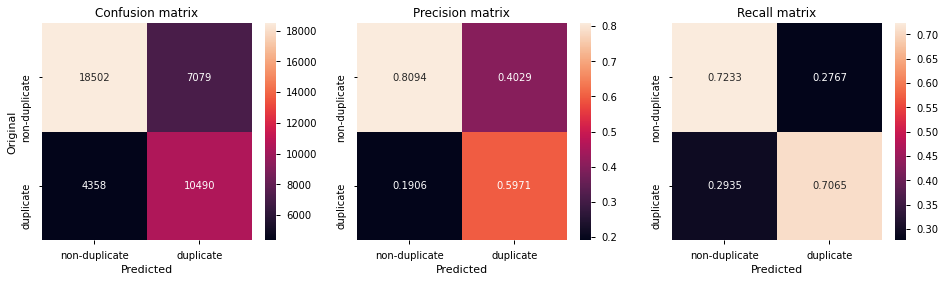

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68720	test-logloss:0.68720
[100]	train-logloss:0.51885	test-logloss:0.51805
[200]	train-logloss:0.50884	test-logloss:0.50767
[300]	train-logloss:0.50808	test-logloss:0.50679
[399]	train-logloss:0.50800	test-logloss:0.50668


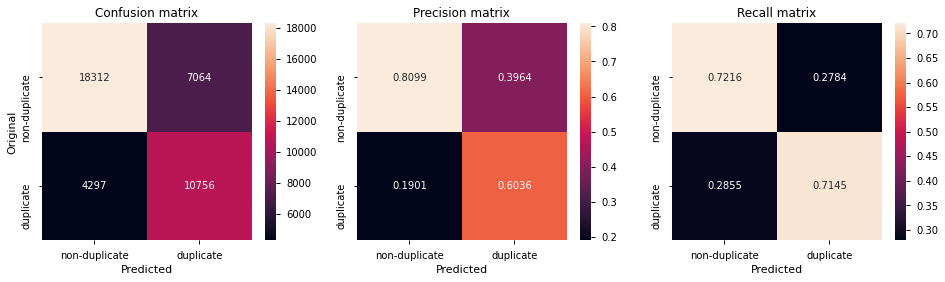

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68720	test-logloss:0.68720
[100]	train-logloss:0.51865	test-logloss:0.51926
[200]	train-logloss:0.50861	test-logloss:0.50951
[300]	train-logloss:0.50784	test-logloss:0.50883
[399]	train-logloss:0.50776	test-logloss:0.50878


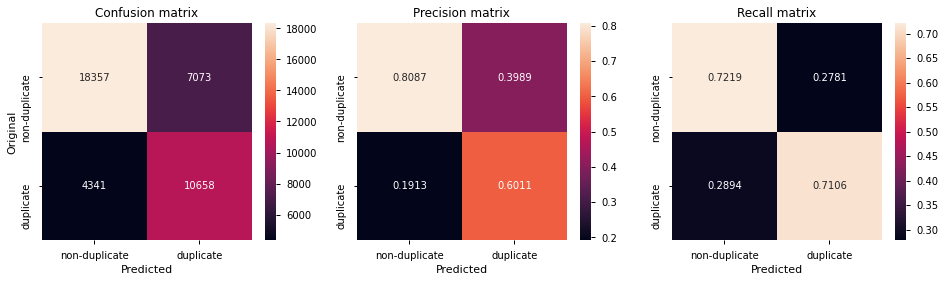

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68723	test-logloss:0.68704
[100]	train-logloss:0.51965	test-logloss:0.51166
[200]	train-logloss:0.50969	test-logloss:0.50022
[300]	train-logloss:0.50894	test-logloss:0.49920
[399]	train-logloss:0.50886	test-logloss:0.49909


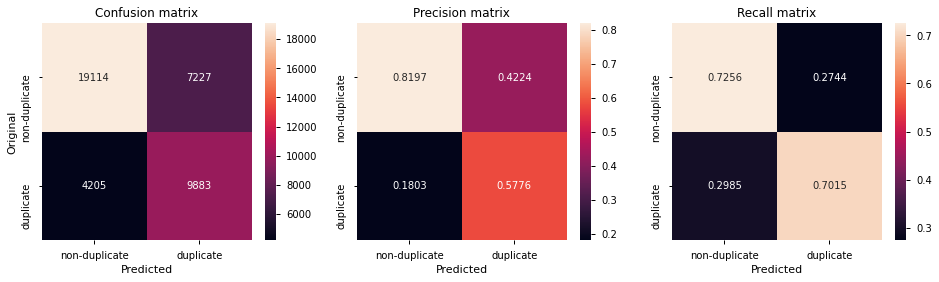

AVG Predicted 0.5968 Recall 0.7054 F1 0.6466 Accuracy 0.7153


In [21]:
for train_idx, test_idx in kfold.split(cosine_sim):
    print(train_idx, test_idx)
    
    x_train = pd.DataFrame()
    x_train['cosine_sim'] = [cosine_sim[i] for i in train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test = pd.DataFrame()
    x_test['cosine_sim'] = [cosine_sim[i] for i in test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
    
print("AVG Predicted {:.4f} Recall {:.4f} F1 {:.4f} Accuracy {:.4f}".format(np.average(predicteds), np.average(recalls), np.average(f1s), np.average(accuracies)))
recalls.clear()
accuracies.clear()
predicteds.clear()
f1s.clear()

Cross similarity

In [22]:
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder('cross-encoder/quora-distilroberta-base')

sub_set2_size = 32768
total_subset = len(df_train) // sub_set2_size

cross_sim = []
for g, sub_df in df_train.groupby(np.arange(len(df_train)) // sub_set2_size):
    print("Processing cross", g, total_subset)

    sub_cleaned_q1 = [clean_text(q) for q in sub_df['question1']]
    sub_cleaned_q2 = [clean_text(q) for q in sub_df['question2']]
    sentence_combinations = [[q1, q2] for q1,q2 in zip(sub_cleaned_q1, sub_cleaned_q2)]

    cross_scores = cross_encoder.predict(sentence_combinations)
    sub_cross_sim = [cross.item() for cross in cross_scores]
    del sentence_combinations, sub_cleaned_q1, sub_cleaned_q2, cross_scores

    cross_sim.extend(sub_cross_sim)

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/148 [00:00<?, ?B/s]

Processing cross 0 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 1 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 2 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 3 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 4 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 5 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 6 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 7 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 8 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 9 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 10 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 11 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 12 12


Batches:   0%|          | 0/347 [00:00<?, ?it/s]

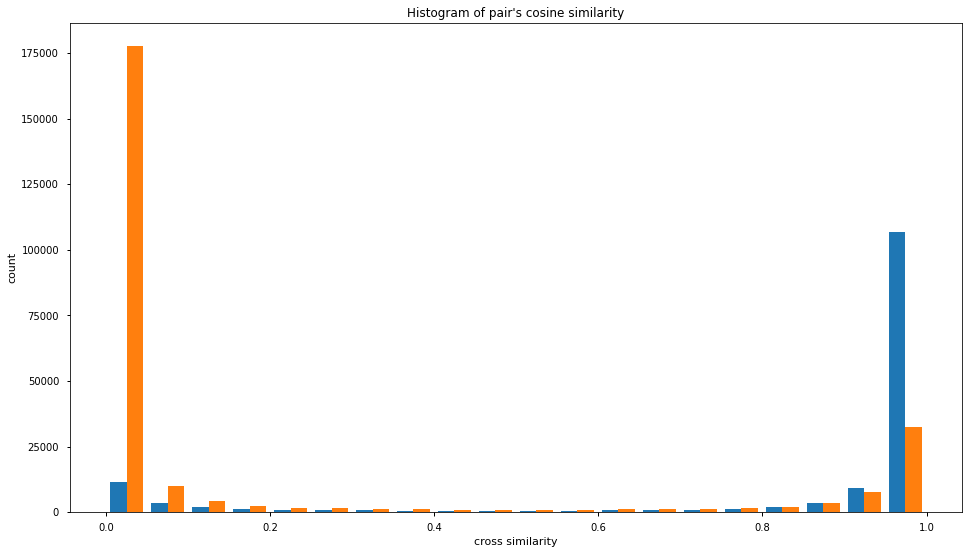

In [23]:
# is_duplicated = df_train['is_duplicate'].tolist()

cross_sim_duplicate = [cross_sim[idx] for idx,val in enumerate(is_duplicated) if val == 1]
cross_sim_nonduplicate = [cross_sim[idx] for idx,val in enumerate(is_duplicated) if val == 0]

plt.figure(figsize=(16, 9))
# plt.yscale('log')
plt.hist([cross_sim_duplicate, cross_sim_nonduplicate], bins=20, label=['duplicate', 'non-duplicate'])
plt.title("Histogram of pair's cosine similarity")
plt.xlabel('cross similarity')
plt.ylabel('count')
print()

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68334	test-logloss:0.68344
[100]	train-logloss:0.40500	test-logloss:0.40909
[200]	train-logloss:0.38837	test-logloss:0.39308
[300]	train-logloss:0.38721	test-logloss:0.39204
[399]	train-logloss:0.38711	test-logloss:0.39197


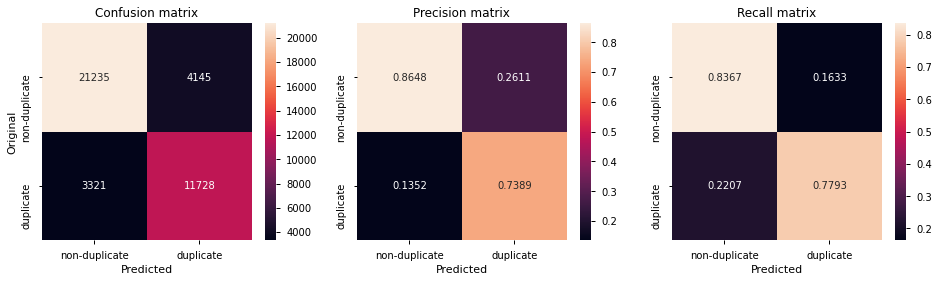

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68336	test-logloss:0.68335
[100]	train-logloss:0.40549	test-logloss:0.40518
[200]	train-logloss:0.38885	test-logloss:0.38882
[300]	train-logloss:0.38767	test-logloss:0.38780
[394]	train-logloss:0.38759	test-logloss:0.38778


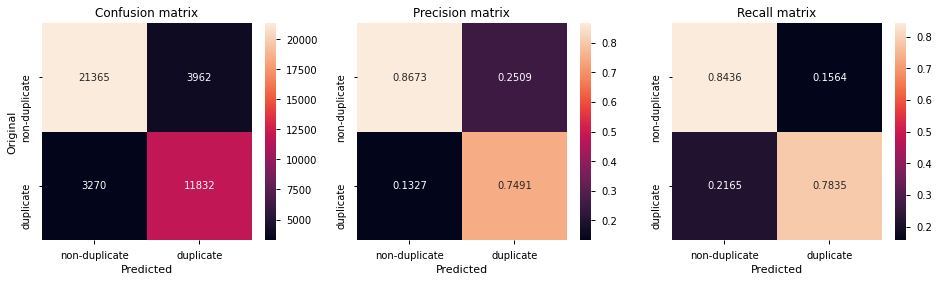

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68336	test-logloss:0.68335
[100]	train-logloss:0.40564	test-logloss:0.40421
[200]	train-logloss:0.38905	test-logloss:0.38711
[300]	train-logloss:0.38788	test-logloss:0.38588
[399]	train-logloss:0.38779	test-logloss:0.38580


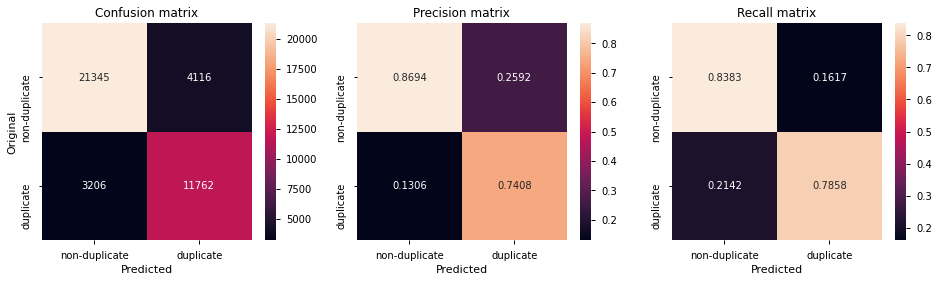

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68337	test-logloss:0.68328
[100]	train-logloss:0.40580	test-logloss:0.40260
[200]	train-logloss:0.38919	test-logloss:0.38570
[300]	train-logloss:0.38803	test-logloss:0.38455
[399]	train-logloss:0.38794	test-logloss:0.38450


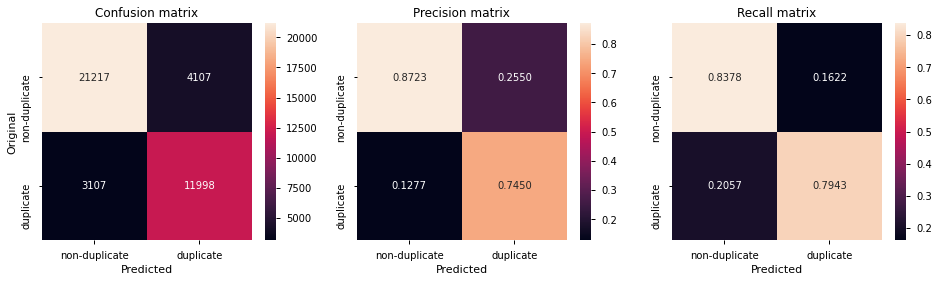

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68335	test-logloss:0.68344
[100]	train-logloss:0.40514	test-logloss:0.40810
[200]	train-logloss:0.38852	test-logloss:0.39171
[300]	train-logloss:0.38736	test-logloss:0.39058
[399]	train-logloss:0.38727	test-logloss:0.39051


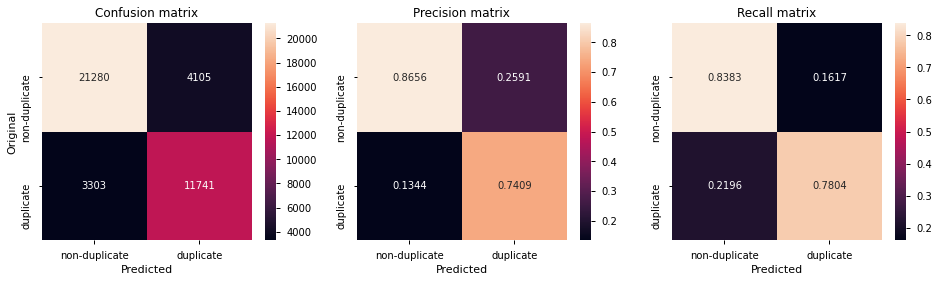

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68335	test-logloss:0.68341
[100]	train-logloss:0.40522	test-logloss:0.40750
[200]	train-logloss:0.38857	test-logloss:0.39123
[300]	train-logloss:0.38740	test-logloss:0.39017
[386]	train-logloss:0.38732	test-logloss:0.39015


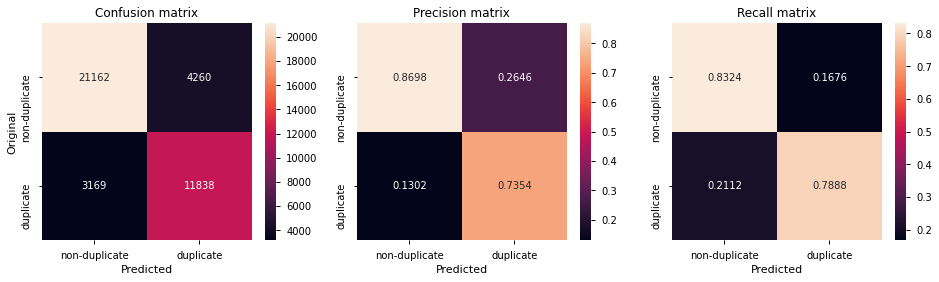

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68336	test-logloss:0.68334
[100]	train-logloss:0.40554	test-logloss:0.40465
[200]	train-logloss:0.38896	test-logloss:0.38775
[300]	train-logloss:0.38781	test-logloss:0.38649
[399]	train-logloss:0.38771	test-logloss:0.38638


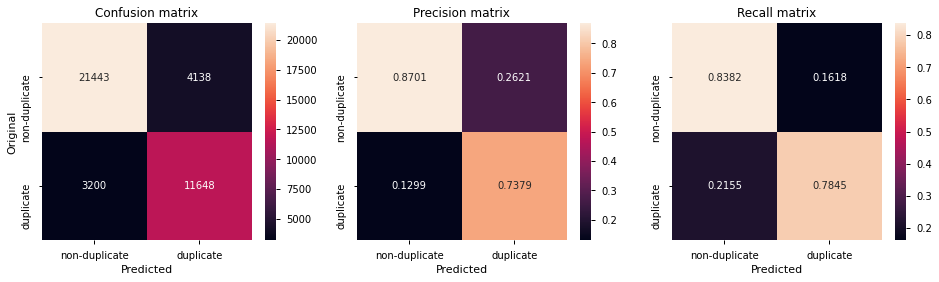

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68336	test-logloss:0.68336
[100]	train-logloss:0.40554	test-logloss:0.40493
[200]	train-logloss:0.38895	test-logloss:0.38802
[300]	train-logloss:0.38779	test-logloss:0.38675
[399]	train-logloss:0.38770	test-logloss:0.38666


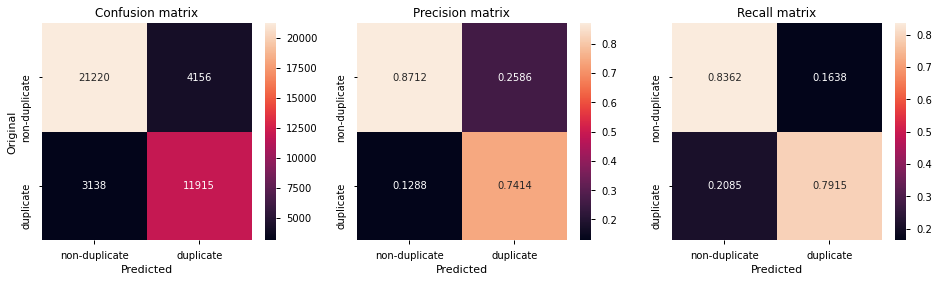

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68336	test-logloss:0.68338
[100]	train-logloss:0.40530	test-logloss:0.40647
[200]	train-logloss:0.38864	test-logloss:0.39052
[300]	train-logloss:0.38747	test-logloss:0.38954
[399]	train-logloss:0.38738	test-logloss:0.38952


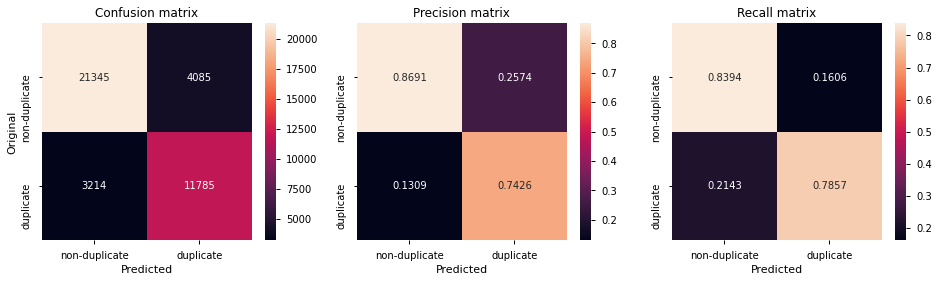

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68336	test-logloss:0.68329
[100]	train-logloss:0.40562	test-logloss:0.40394
[200]	train-logloss:0.38903	test-logloss:0.38721
[300]	train-logloss:0.38787	test-logloss:0.38609
[395]	train-logloss:0.38778	test-logloss:0.38608


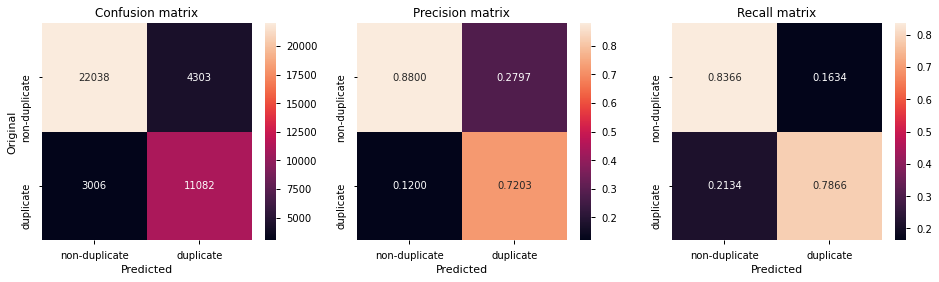

AVG Predicted 0.7392 Recall 0.7861 F1 0.7619 Accuracy 0.8187


In [24]:
for train_idx, test_idx in kfold.split(cross_sim):
    print(train_idx, test_idx)
    
    x_train = pd.DataFrame()
    x_train['cross_sim'] = [cross_sim[i] for i in train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test = pd.DataFrame()
    x_test['cross_sim'] = [cross_sim[i] for i in test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
    
print("AVG Predicted {:.4f} Recall {:.4f} F1 {:.4f} Accuracy {:.4f}".format(np.average(predicteds), np.average(recalls), np.average(f1s), np.average(accuracies)))
recalls.clear()
accuracies.clear()
predicteds.clear()
f1s.clear()

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68321	test-logloss:0.68331
[100]	train-logloss:0.39831	test-logloss:0.40309
[200]	train-logloss:0.37970	test-logloss:0.38557
[300]	train-logloss:0.37801	test-logloss:0.38423
[399]	train-logloss:0.37771	test-logloss:0.38412


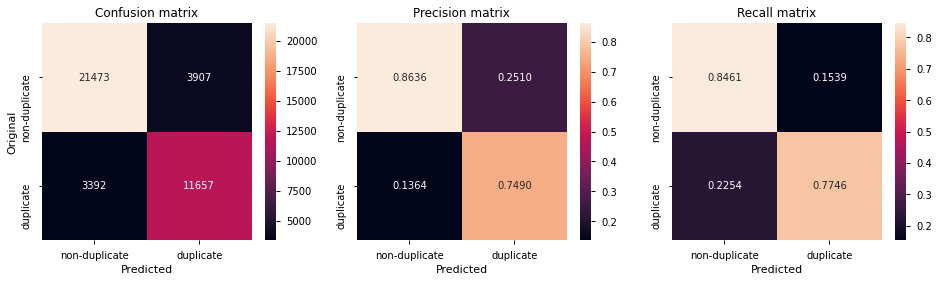

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68323	test-logloss:0.68322
[100]	train-logloss:0.39889	test-logloss:0.39879
[200]	train-logloss:0.38027	test-logloss:0.38056
[300]	train-logloss:0.37860	test-logloss:0.37906
[399]	train-logloss:0.37831	test-logloss:0.37884


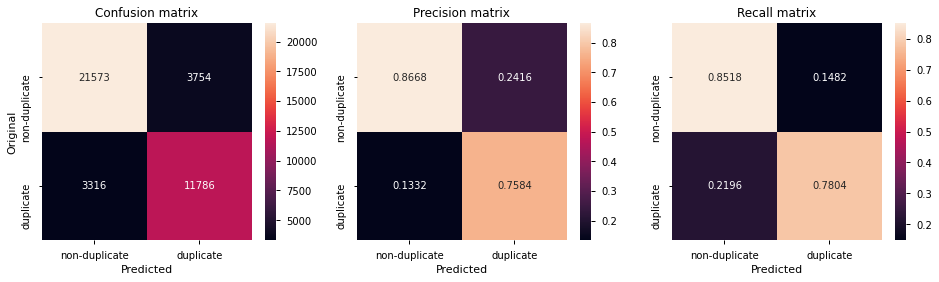

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68323	test-logloss:0.68322
[100]	train-logloss:0.39905	test-logloss:0.39792
[200]	train-logloss:0.38049	test-logloss:0.37894
[300]	train-logloss:0.37881	test-logloss:0.37723
[399]	train-logloss:0.37853	test-logloss:0.37695


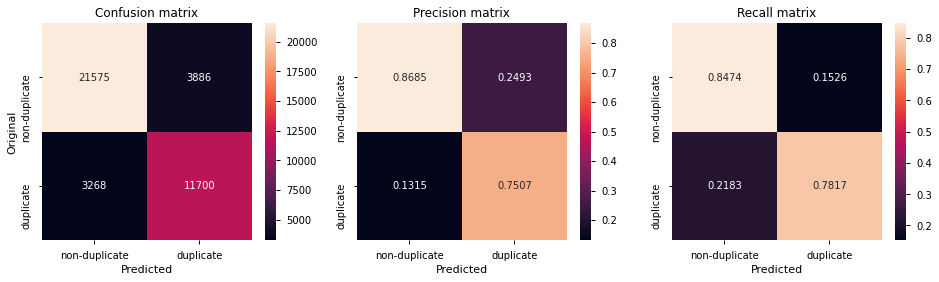

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68324	test-logloss:0.68316
[100]	train-logloss:0.39911	test-logloss:0.39676
[200]	train-logloss:0.38051	test-logloss:0.37817
[300]	train-logloss:0.37882	test-logloss:0.37669
[399]	train-logloss:0.37854	test-logloss:0.37656


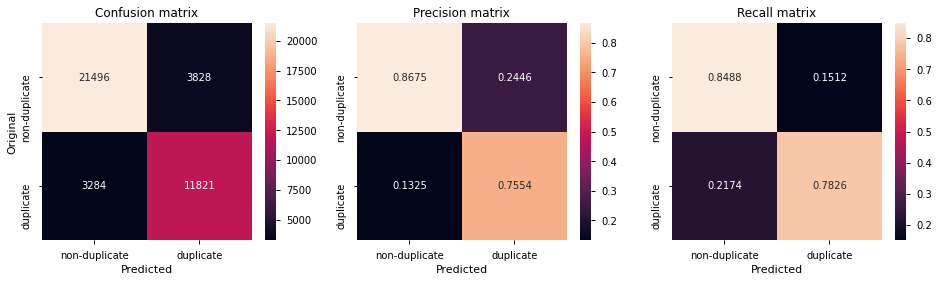

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68322	test-logloss:0.68332
[100]	train-logloss:0.39848	test-logloss:0.40207
[200]	train-logloss:0.37987	test-logloss:0.38387
[300]	train-logloss:0.37819	test-logloss:0.38233
[399]	train-logloss:0.37791	test-logloss:0.38217


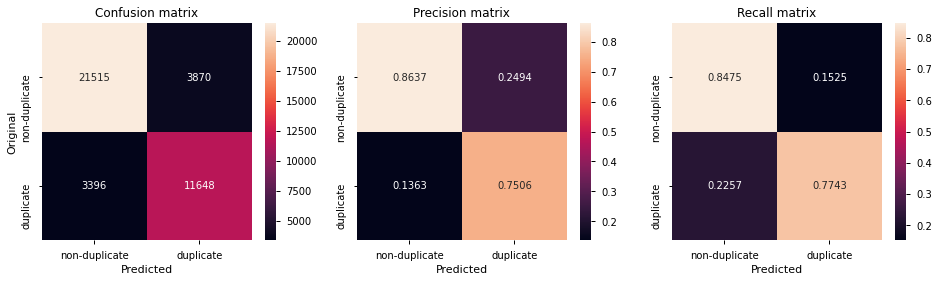

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68322	test-logloss:0.68328
[100]	train-logloss:0.39861	test-logloss:0.40110
[200]	train-logloss:0.37996	test-logloss:0.38316
[300]	train-logloss:0.37826	test-logloss:0.38181
[399]	train-logloss:0.37796	test-logloss:0.38166


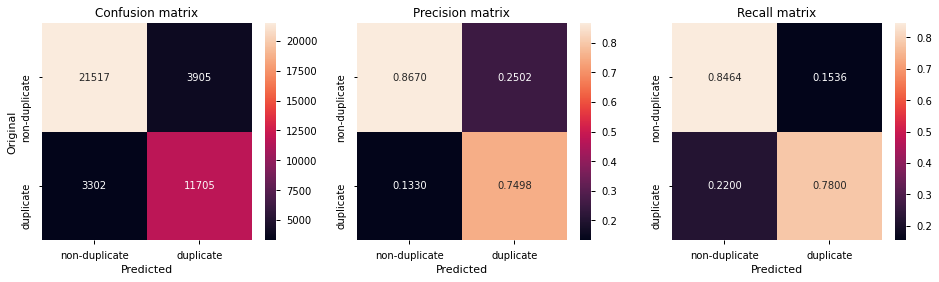

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68323	test-logloss:0.68321
[100]	train-logloss:0.39893	test-logloss:0.39844
[200]	train-logloss:0.38035	test-logloss:0.37970
[300]	train-logloss:0.37868	test-logloss:0.37796
[399]	train-logloss:0.37839	test-logloss:0.37778


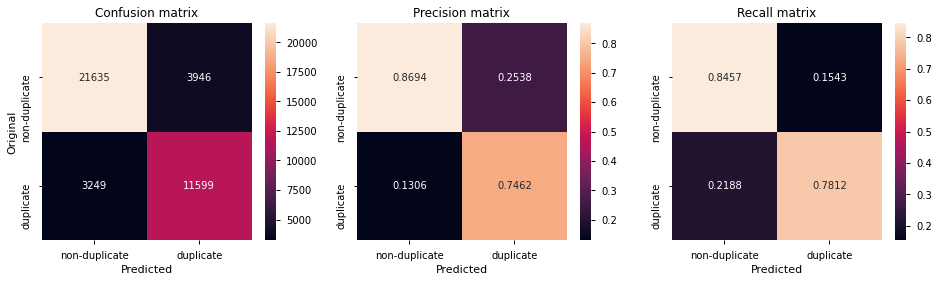

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68323	test-logloss:0.68324
[100]	train-logloss:0.39899	test-logloss:0.39842
[200]	train-logloss:0.38043	test-logloss:0.37943
[300]	train-logloss:0.37875	test-logloss:0.37758
[399]	train-logloss:0.37846	test-logloss:0.37731


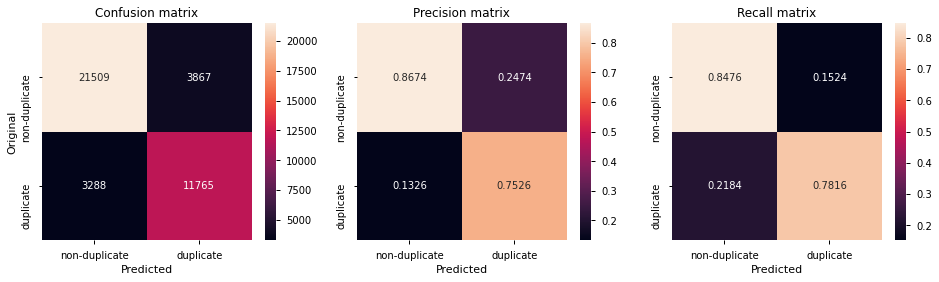

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68323	test-logloss:0.68324
[100]	train-logloss:0.39869	test-logloss:0.39995
[200]	train-logloss:0.38005	test-logloss:0.38220
[300]	train-logloss:0.37836	test-logloss:0.38079
[399]	train-logloss:0.37807	test-logloss:0.38064


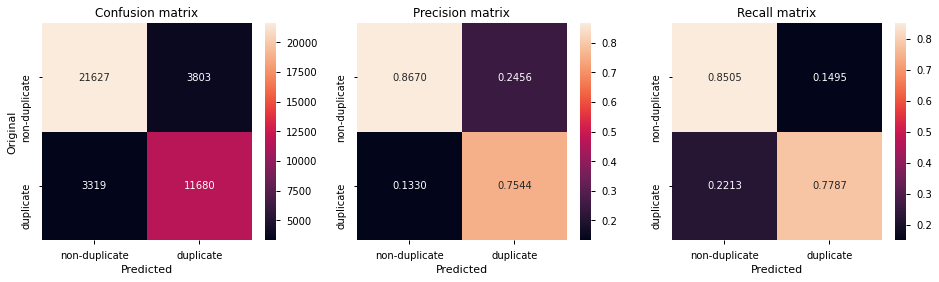

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68323	test-logloss:0.68316
[100]	train-logloss:0.39911	test-logloss:0.39696
[200]	train-logloss:0.38056	test-logloss:0.37810
[300]	train-logloss:0.37888	test-logloss:0.37640
[399]	train-logloss:0.37860	test-logloss:0.37616


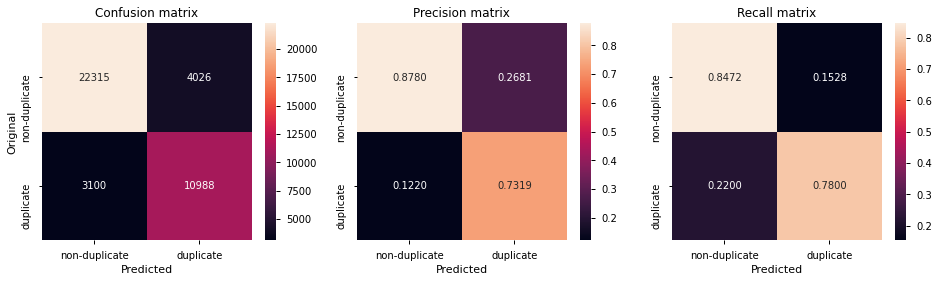

AVG Predicted 0.7499 Recall 0.7795 F1 0.7644 Accuracy 0.8226


In [25]:
for train_idx, test_idx in kfold.split(cross_sim):
    print(train_idx, test_idx)
    
    x_train = pd.DataFrame()
    x_train['cross_sim'] = [cross_sim[i] for i in train_idx]
    x_train['cosine_sim'] = [cosine_sim[i] for i in train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test = pd.DataFrame()
    x_test['cross_sim'] = [cross_sim[i] for i in test_idx]
    x_test['cosine_sim'] = [cosine_sim[i] for i in test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
    
print("AVG Predicted {:.4f} Recall {:.4f} F1 {:.4f} Accuracy {:.4f}".format(np.average(predicteds), np.average(recalls), np.average(f1s), np.average(accuracies)))
recalls.clear()
accuracies.clear()
predicteds.clear()
f1s.clear()

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68227	test-logloss:0.68236
[100]	train-logloss:0.36765	test-logloss:0.37134
[200]	train-logloss:0.34479	test-logloss:0.34930
[300]	train-logloss:0.34184	test-logloss:0.34669
[399]	train-logloss:0.34091	test-logloss:0.34598


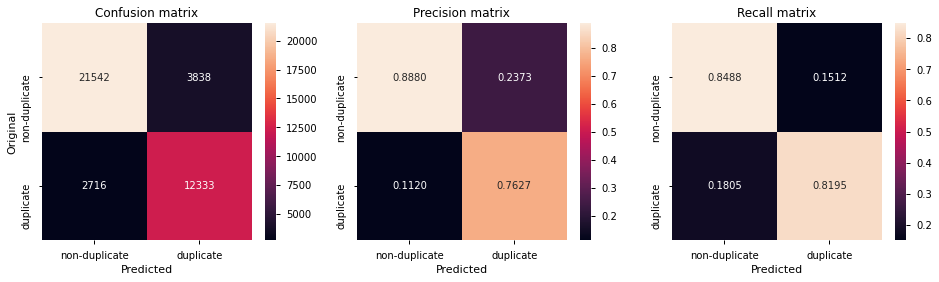

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68229	test-logloss:0.68227
[100]	train-logloss:0.36817	test-logloss:0.36732
[200]	train-logloss:0.34534	test-logloss:0.34447
[300]	train-logloss:0.34238	test-logloss:0.34172
[399]	train-logloss:0.34148	test-logloss:0.34102


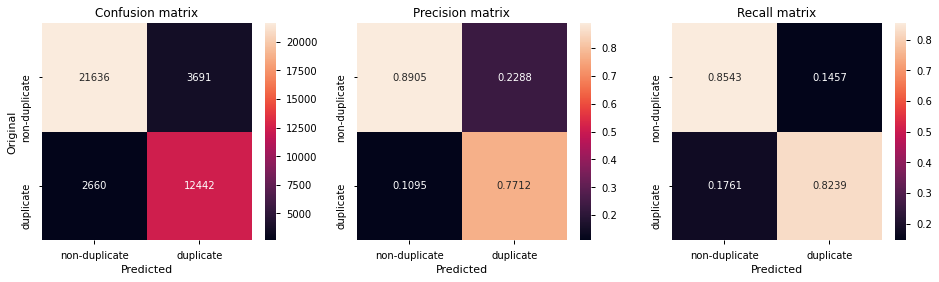

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68229	test-logloss:0.68227
[100]	train-logloss:0.36821	test-logloss:0.36720
[200]	train-logloss:0.34538	test-logloss:0.34412
[300]	train-logloss:0.34242	test-logloss:0.34118
[399]	train-logloss:0.34147	test-logloss:0.34036


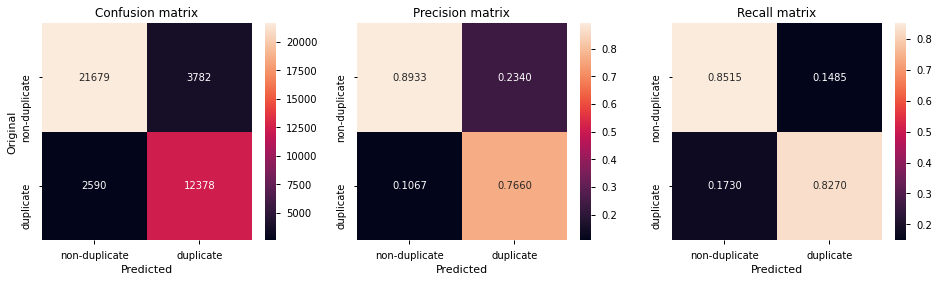

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68229	test-logloss:0.68224
[100]	train-logloss:0.36831	test-logloss:0.36617
[200]	train-logloss:0.34553	test-logloss:0.34295
[300]	train-logloss:0.34262	test-logloss:0.33993
[399]	train-logloss:0.34168	test-logloss:0.33902


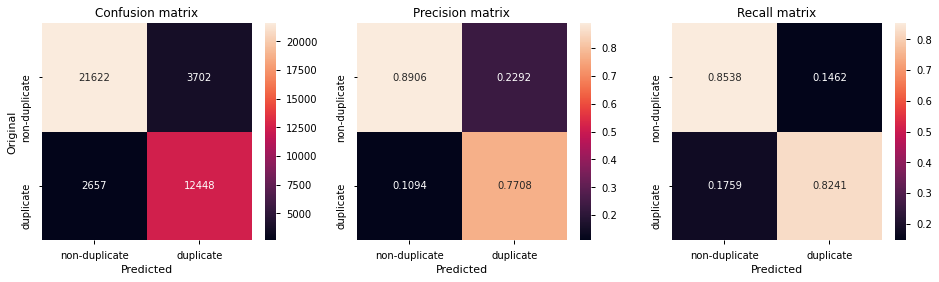

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68227	test-logloss:0.68239
[100]	train-logloss:0.36763	test-logloss:0.37171
[200]	train-logloss:0.34475	test-logloss:0.34956
[300]	train-logloss:0.34181	test-logloss:0.34694
[399]	train-logloss:0.34087	test-logloss:0.34625


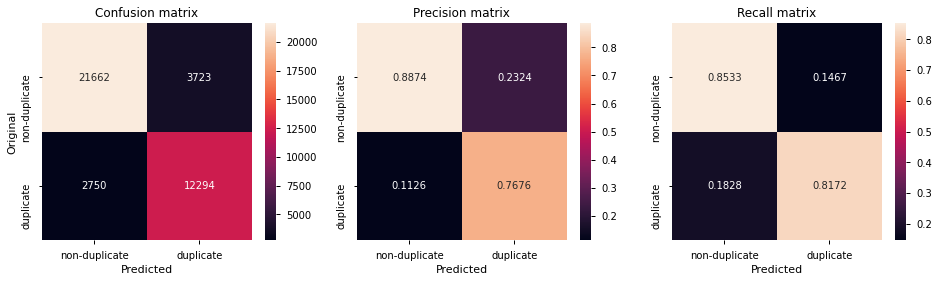

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68228	test-logloss:0.68233
[100]	train-logloss:0.36787	test-logloss:0.36960
[200]	train-logloss:0.34502	test-logloss:0.34717
[300]	train-logloss:0.34206	test-logloss:0.34452
[399]	train-logloss:0.34111	test-logloss:0.34375


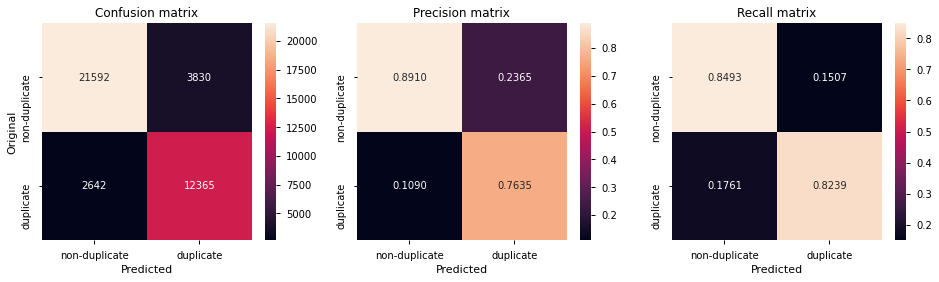

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68229	test-logloss:0.68227
[100]	train-logloss:0.36810	test-logloss:0.36767
[200]	train-logloss:0.34531	test-logloss:0.34463
[300]	train-logloss:0.34238	test-logloss:0.34163
[399]	train-logloss:0.34142	test-logloss:0.34073


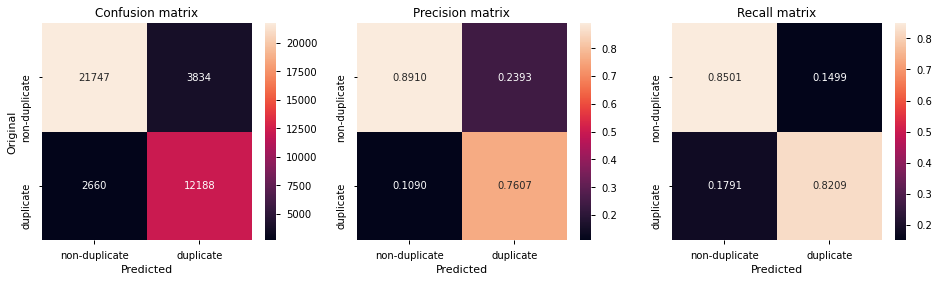

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68230	test-logloss:0.68226
[100]	train-logloss:0.36844	test-logloss:0.36571
[200]	train-logloss:0.34563	test-logloss:0.34217
[300]	train-logloss:0.34272	test-logloss:0.33903
[399]	train-logloss:0.34175	test-logloss:0.33806


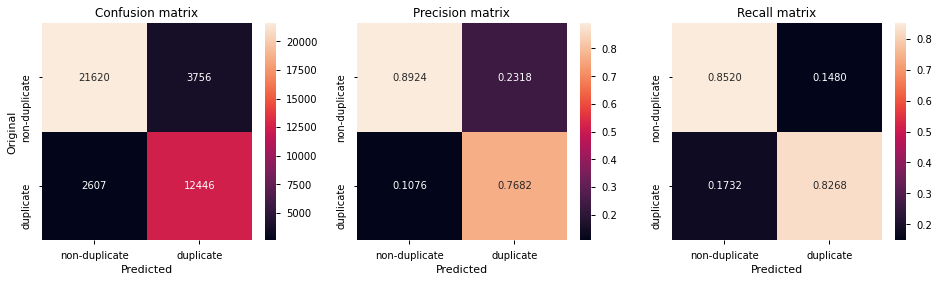

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68228	test-logloss:0.68231
[100]	train-logloss:0.36774	test-logloss:0.37001
[200]	train-logloss:0.34482	test-logloss:0.34847
[300]	train-logloss:0.34190	test-logloss:0.34601
[399]	train-logloss:0.34098	test-logloss:0.34527


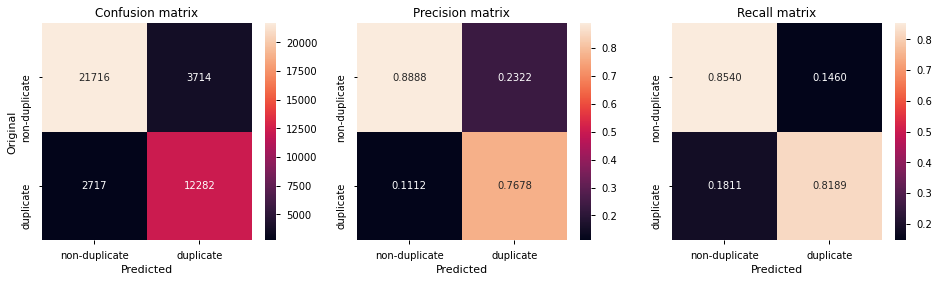

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68229	test-logloss:0.68222
[100]	train-logloss:0.36817	test-logloss:0.36683
[200]	train-logloss:0.34539	test-logloss:0.34404
[300]	train-logloss:0.34247	test-logloss:0.34117
[399]	train-logloss:0.34153	test-logloss:0.34035


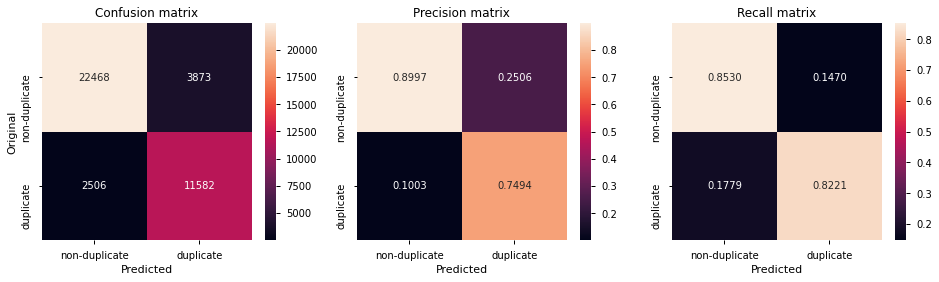

AVG Predicted 0.7648 Recall 0.8224 F1 0.7925 Accuracy 0.8411


In [26]:
for train_idx, test_idx in kfold.split(cross_sim):
    print(train_idx, test_idx)
    
    x_train = pd.DataFrame()
    x_train['word_match'] = train_word_match[train_idx]
    x_train['tfidf_word_match'] = tfidf_train_word_match[train_idx]
    x_train['cross_sim'] = [cross_sim[i] for i in train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test = pd.DataFrame()
    x_test['word_match'] = train_word_match[test_idx]
    x_test['tfidf_word_match'] = tfidf_train_word_match[test_idx]
    x_test['cross_sim'] = [cross_sim[i] for i in test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
    
print("AVG Predicted {:.4f} Recall {:.4f} F1 {:.4f} Accuracy {:.4f}".format(np.average(predicteds), np.average(recalls), np.average(f1s), np.average(accuracies)))
recalls.clear()
accuracies.clear()
predicteds.clear()
f1s.clear()

Combination of deeplearning approach and NLP approach

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68227	test-logloss:0.68236
[100]	train-logloss:0.36761	test-logloss:0.37128
[200]	train-logloss:0.34436	test-logloss:0.34906
[300]	train-logloss:0.34113	test-logloss:0.34632
[399]	train-logloss:0.33973	test-logloss:0.34521


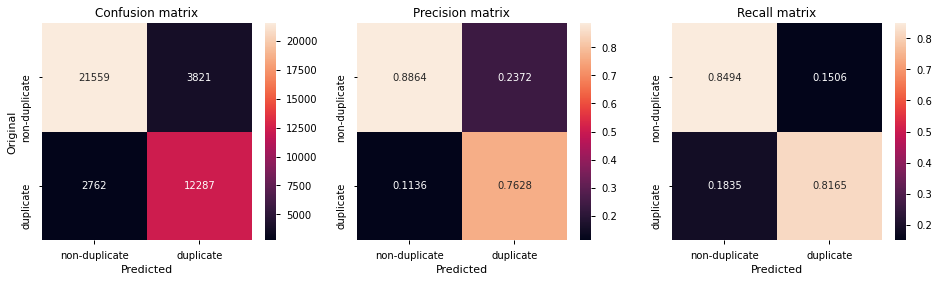

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68229	test-logloss:0.68227
[100]	train-logloss:0.36812	test-logloss:0.36728
[200]	train-logloss:0.34496	test-logloss:0.34414
[300]	train-logloss:0.34165	test-logloss:0.34107
[399]	train-logloss:0.34031	test-logloss:0.33996


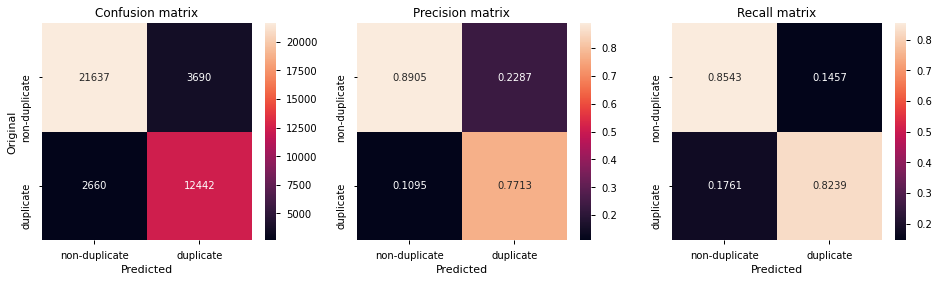

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68229	test-logloss:0.68227
[100]	train-logloss:0.36817	test-logloss:0.36717
[200]	train-logloss:0.34501	test-logloss:0.34373
[300]	train-logloss:0.34172	test-logloss:0.34049
[399]	train-logloss:0.34033	test-logloss:0.33930


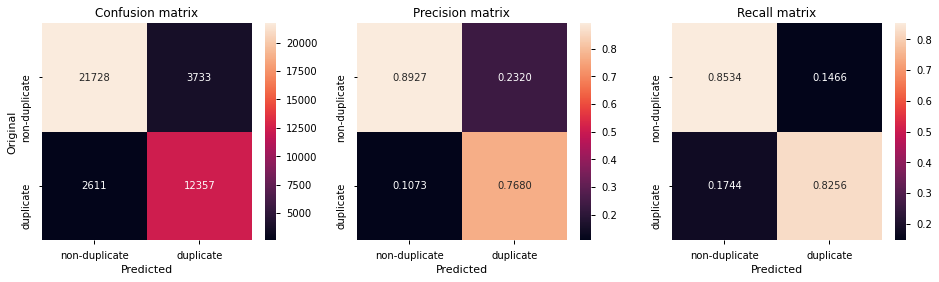

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68229	test-logloss:0.68224
[100]	train-logloss:0.36827	test-logloss:0.36615
[200]	train-logloss:0.34511	test-logloss:0.34274
[300]	train-logloss:0.34188	test-logloss:0.33958
[399]	train-logloss:0.34044	test-logloss:0.33837


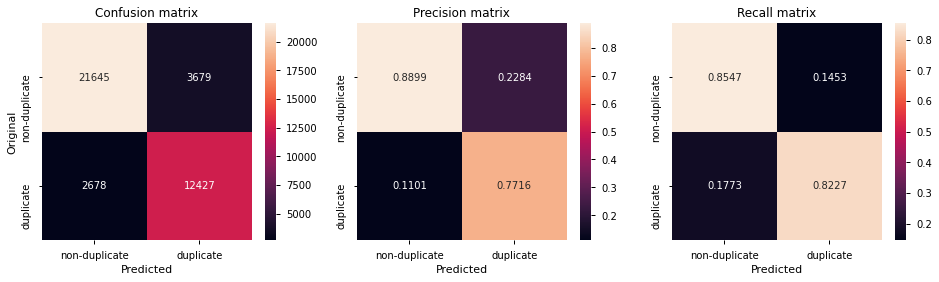

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68227	test-logloss:0.68239
[100]	train-logloss:0.36756	test-logloss:0.37172
[200]	train-logloss:0.34436	test-logloss:0.34928
[300]	train-logloss:0.34103	test-logloss:0.34622
[399]	train-logloss:0.33968	test-logloss:0.34515


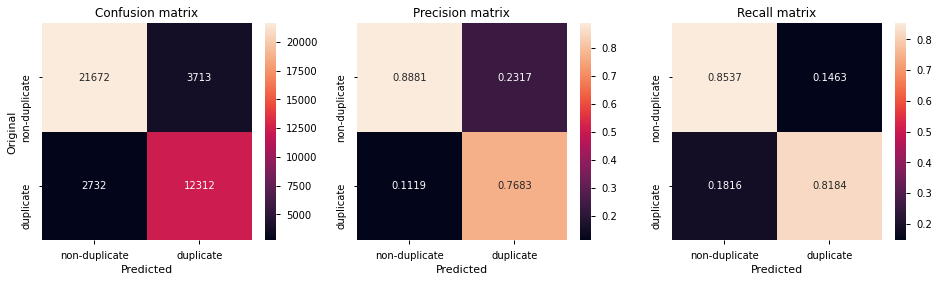

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68228	test-logloss:0.68233
[100]	train-logloss:0.36784	test-logloss:0.36954
[200]	train-logloss:0.34465	test-logloss:0.34673
[300]	train-logloss:0.34135	test-logloss:0.34371
[399]	train-logloss:0.33996	test-logloss:0.34250


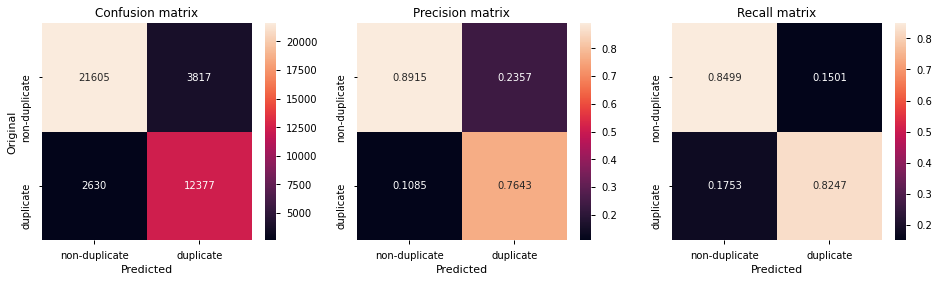

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68229	test-logloss:0.68227
[100]	train-logloss:0.36805	test-logloss:0.36762
[200]	train-logloss:0.34492	test-logloss:0.34428
[300]	train-logloss:0.34165	test-logloss:0.34096
[399]	train-logloss:0.34031	test-logloss:0.33961


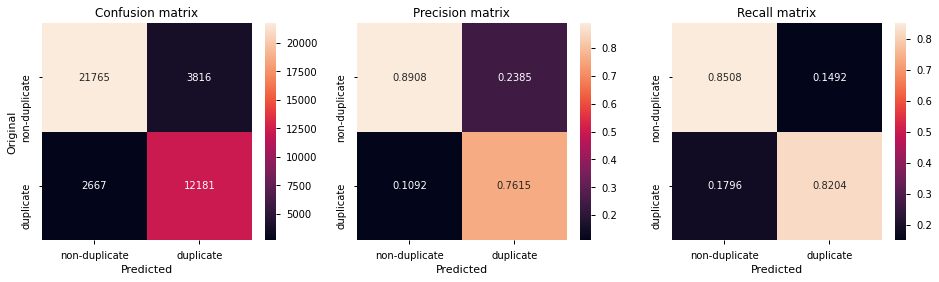

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68230	test-logloss:0.68226
[100]	train-logloss:0.36838	test-logloss:0.36573
[200]	train-logloss:0.34524	test-logloss:0.34193
[300]	train-logloss:0.34200	test-logloss:0.33855
[399]	train-logloss:0.34057	test-logloss:0.33724


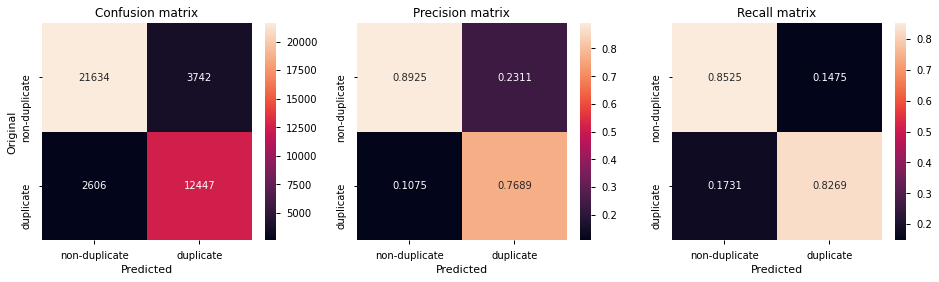

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68228	test-logloss:0.68231
[100]	train-logloss:0.36769	test-logloss:0.36998
[200]	train-logloss:0.34445	test-logloss:0.34806
[300]	train-logloss:0.34113	test-logloss:0.34531
[399]	train-logloss:0.33984	test-logloss:0.34430


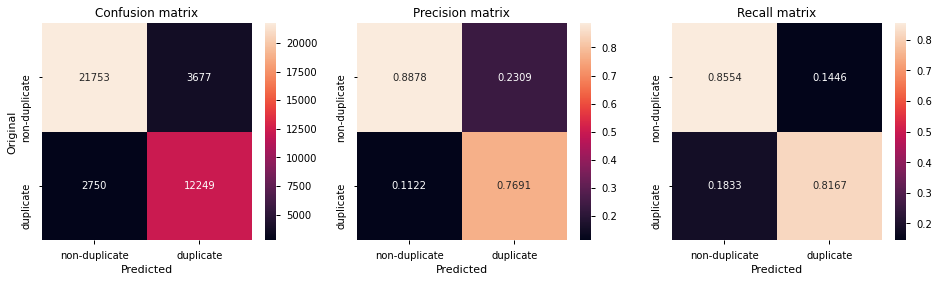

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68229	test-logloss:0.68222
[100]	train-logloss:0.36812	test-logloss:0.36675
[200]	train-logloss:0.34502	test-logloss:0.34364
[300]	train-logloss:0.34173	test-logloss:0.34047
[399]	train-logloss:0.34039	test-logloss:0.33927


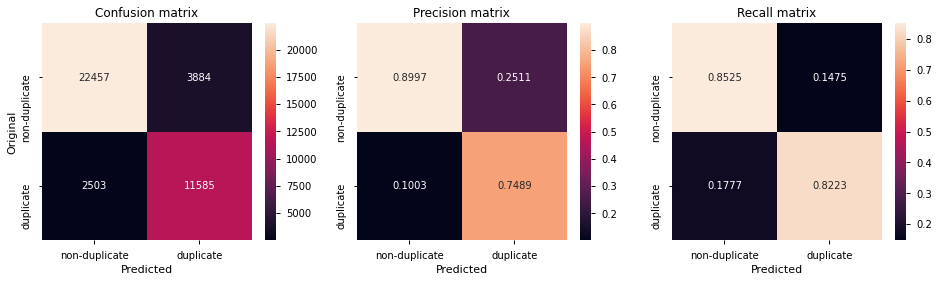

AVG Predicted 0.7655 Recall 0.8218 F1 0.7926 Accuracy 0.8413


In [27]:
for train_idx, test_idx in kfold.split(train_word_match):
    print(train_idx, test_idx)
    x_train = pd.DataFrame()
    x_test = pd.DataFrame()
    
    x_train['word_match'] = train_word_match[train_idx]
    x_train['tfidf_word_match'] = tfidf_train_word_match[train_idx]
    x_train['cross_sim'] =  [cross_sim[i] for i in train_idx]
    x_train['cosine_sim'] =  [cosine_sim[i] for i in train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test['word_match'] = train_word_match[test_idx]
    x_test['tfidf_word_match'] = tfidf_train_word_match[test_idx]
    x_test['cross_sim'] =  [cross_sim[i] for i in test_idx]
    x_test['cosine_sim'] =  [cosine_sim[i] for i in test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
    
    
print("AVG Predicted {:.4f} Recall {:.4f} F1 {:.4f} Accuracy {:.4f}".format(np.average(predicteds), np.average(recalls), np.average(f1s), np.average(accuracies)))
recalls.clear()
accuracies.clear()
predicteds.clear()
f1s.clear()

In [31]:
import pickle
with open('xgboost_pair.pkl', "wb") as fOut:
    pickle.dump({'bst': bst,'params': params},fOut, protocol=pickle.HIGHEST_PROTOCOL)